シェイクスピアの作品を元に"more"といった候補フレーズをモデルに供給し、そのフレーズに続く単語をモデルに予測させる

In [1]:
import os
import re
import string
import requests
import numpy as np
import collections
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

sess = tf.Session()

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# RNNのパラメータ設定
min_word_freq = 5 # 出現頻度がこの値以下の単語を除外
rnn_size = 128 # RNNモデルのサイズ
embedding_size = rnn_size # 埋め込みサイズ
epochs = 10 #  データを処理する回数
batch_size = 100 # 一度にトレーニングするサンプル数
learning_rate = 0.001 # 学習率
training_seq_len = 50 # 前後の単語数（左右に２５ずつ）
save_every = 500 
eval_every = 50 

In [3]:
# テスト文のリスト
prime_texts = ['thou art more', 'to be or not to', 'wherefore art thou']

In [4]:
# データフォルダ、データファイル、モデルファイルを設定
data_dir = 'temp'
data_file = 'shakespeare.txt'
model_path = 'shakespeare_model'
full_model_dir = os.path.join(data_dir, model_path)

# データから余計なものを取り除く（(-)と(')を残すのはシェイクスピアがよく使用していたから）
punctuation = string.punctuation
punctuation = ''.join([x for x in punctuation if x not in ['-', "'"]])

In [13]:
# データの取得
# モデルフォルダを作成
if not os.path.exists(full_model_dir):
    os.makedirs(full_model_dir)

# データフォルダを作成
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
print('Loading Shakespeare Data')
# ファイルがダウンロードされているかどうか確認
if not os.path.isfile(os.path.join(data_dir, data_file)):
    print('Not found, downloading Shakespeare texts from www.gutenberg.org')
    shakespeare_url = 'http://www.gutenberg.org/cache/epub/100/pg100.txt'
    # テキスト取得
    response = requests.get(shakespeare_url)
    shakespeare_file = response.content
    # デコード
    s_text = shakespeare_file.decode('utf-8')
    # 最初の生命用の段落を削除
    s_text = s_text[7675:]
    # 改行を削除
    s_text = s_text.replace('\r\n', '')
    s_text = s_text.replace('\n', '')
    
    # ファイルに保存
    with open(os.path.join(data_dir, data_file), 'w') as out_conn:
        out_conn.write(s_text)
else:
    # すでにファイルがある場合は、ロード
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        s_text = file_conn.read().replace('\n', '')

print("downloading is done")

Loading Shakespeare Data
downloading is done


In [14]:
# データから句読点と余分な空白を削除
print('Cleaning Text')
s_text = re.sub(r'[{}]'.format(punctuation), ' ', s_text)
s_text = re.sub('\s+', ' ', s_text ).strip().lower()
print('Done loading/cleaning.')

Cleaning Text
Done loading/cleaning.


In [15]:
# 辞書を作成する関数（1つ目は単語からインデックスのマッピング、２つ目はインデックスから単語へのマッピング）
def build_vocab(text, min_word_freq):
    word_counts = collections.Counter(text.split(' '))
    # 出現頻度がしきい値を超える単語を対象
    word_counts = {key:val for key, val in word_counts.items() if val>min_word_freq}
    # 単語 --> インデックス
    words = word_counts.keys()
    vocab_to_ix_dict = {key:(ix+1) for ix, key in enumerate(words)}
    # 不明なキー--> インデックス０とする
    vocab_to_ix_dict['unknown']=0
    # インデックス --> 単語
    ix_to_vocab_dict = {val:key for key,val in vocab_to_ix_dict.items()}
    
    return(ix_to_vocab_dict, vocab_to_ix_dict)

# シェイクスピアの辞書を作成
print('Building Shakespeare Vocab')
ix2vocab, vocab2ix = build_vocab(s_text, min_word_freq)
vocab_size = len(ix2vocab) + 1
print('Vocabulary Length = {}'.format(vocab_size))
# 正しく実行されているか確認
assert(len(ix2vocab) == len(vocab2ix))

Building Shakespeare Vocab
Vocabulary Length = 8009


In [16]:
# テキストデータからインデックスの配列を作成
# テキストを単語ベクトルに変換
s_text_words = s_text.split(' ')
s_text_ix = []
for ix, x in enumerate(s_text_words):
    try:
        s_text_ix.append(vocab2ix[x])
    except:
        s_text_ix.append(0)
s_text_ix = np.array(s_text_ix)

In [18]:
# LSTMモデルの作成（理想的には、別のPythonファイルに保存してimportできるようにする）
class LSTM_Model():
    # モデルのすべての変数と演算を定義
    def __init__(self, embedding_size, rnn_size, batch_size, learning_rate,
                 training_seq_len, vocab_size, infer_sample=False):
        self.embedding_size = embedding_size
        self.rnn_size = rnn_size
        self.vocab_size = vocab_size
        self.infer_sample = infer_sample
        self.learning_rate = learning_rate
        
        if infer_sample:
            self.batch_size = 1
            self.training_seq_len = 1
        else:
            self.batch_size = batch_size
            self.training_seq_len = training_seq_len
        
        self.lstm_cell = tf.contrib.rnn.BasicLSTMCell(self.rnn_size)
        self.initial_state = self.lstm_cell.zero_state(self.batch_size, tf.float32)
        
        self.x_data = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        self.y_output = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        
        with tf.variable_scope('lstm_vars'):
            # ソフトマックスの出力の重み
            W = tf.get_variable('W', [self.rnn_size, self.vocab_size], tf.float32, tf.random_normal_initializer())
            b = tf.get_variable('b', [self.vocab_size], tf.float32, tf.constant_initializer(0.0))
        
            # 埋め込みを定義
            embedding_mat = tf.get_variable('embedding_mat', [self.vocab_size, self.embedding_size],
                                            tf.float32, tf.random_normal_initializer())
                                            
            embedding_output = tf.nn.embedding_lookup(embedding_mat, self.x_data)
            rnn_inputs = tf.split(axis=1, num_or_size_splits=self.training_seq_len, value=embedding_output)
            rnn_inputs_trimmed = [tf.squeeze(x, [1]) for x in rnn_inputs]
            
        # 推測中（テキストの生成中）は、ループ関数を追加
        # i番目の出力から i + 1 番目のにゅう直を取得する方法を定義
        def inferred_loop(prev, count):
            # 隠れ層を適用
            prev_transformed = tf.matmul(prev, W) + b
            # 出力のインデックスを取得
            prev_symbol = tf.stop_gradient(tf.argmax(prev_transformed, 1))
            # 埋め込みベクトルを取得
            output = tf.nn.embedding_lookup(embedding_mat, prev_symbol)
            return(output)

        decoder = tf.contrib.legacy_seq2seq.rnn_decoder
        outputs, last_state = decoder(rnn_inputs_trimmed,
                                      self.initial_state,
                                      self.lstm_cell,
                                      loop_function=inferred_loop if infer_sample else None)
        # 推測されていない出力
        output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, self.rnn_size])
        # ロジットと出力
        self.logit_output = tf.matmul(output, W) + b
        self.model_output = tf.nn.softmax(self.logit_output)

        loss_fun = tf.contrib.legacy_seq2seq.sequence_loss_by_example
        loss = loss_fun([self.logit_output],[tf.reshape(self.y_output, [-1])],
                [tf.ones([self.batch_size * self.training_seq_len])],
                self.vocab_size)
        self.cost = tf.reduce_sum(loss) / (self.batch_size * self.training_seq_len)
        self.final_state = last_state
        gradients, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tf.trainable_variables()), 4.5)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    
    # サンプル（単語）をループ処理してテキストを生成
    def sample(self, sess, words=ix2vocab, vocab=vocab2ix, num=10, prime_text='thou art'):
        state = sess.run(self.lstm_cell.zero_state(1, tf.float32))
        word_list = prime_text.split()
        for word in word_list[:-1]:
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            feed_dict = {self.x_data: x, self.initial_state:state}
            [state] = sess.run([self.final_state], feed_dict=feed_dict)

        out_sentence = prime_text
        word = word_list[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            feed_dict = {self.x_data: x, self.initial_state:state}
            [model_output, state] = sess.run([self.model_output, self.final_state], feed_dict=feed_dict)
            sample = np.argmax(model_output[0])
            if sample == 0:
                break
            word = words[sample]
            out_sentence = out_sentence + ' ' + word
        return(out_sentence)

In [19]:
# LSTMモデルとテストモデルを設定
#LSTMモデルを定義
lstm_model = LSTM_Model(embedding_size, rnn_size, batch_size, learning_rate,
                        training_seq_len, vocab_size)

# テストモデルを定義（このスコープをテストに再利用する）
with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    test_lstm_model = LSTM_Model(embedding_size, rnn_size, batch_size, learning_rate,
                                 training_seq_len, vocab_size, infer_sample=True)

In [20]:
# 保存関数を定義し、バッチサイズで入力テキストを分割する
# モデルの保存関数を定義
saver = tf.train.Saver(tf.global_variables())


# エポックごとにバッチを作成
num_batches = int(len(s_text_ix)/(batch_size * training_seq_len)) + 1
# テキストインデックスを同じサイズの部分配列に分割
batches = np.array_split(s_text_ix, num_batches)
# それらの部分配列の形状を [batch_size, training_seq_len]　に変更
batches = [np.resize(x, [batch_size, training_seq_len]) for x in batches]

# すべての変数を初期化
init = tf.global_variables_initializer()
sess.run(init)

In [21]:
#　トレーニングの開始
train_loss = []
iteration_count = 1
for epoch in range(epochs):
    # 単語インデックスをシャッフル
    random.shuffle(batches)
    # シャッフルしたバッチから目的値を作成
    targets = [np.roll(x, -1, axis=1) for x in batches]
    # エポックの実行を開始
    print('Starting Epoch #{} of {}.'.format(epoch+1, epochs))
    # LSTMの初期状態をエポックごとにリセット
    state = sess.run(lstm_model.initial_state)
    for ix, batch in enumerate(batches):
        training_dict = {lstm_model.x_data: batch, lstm_model.y_output: targets[ix]}
        c, h = lstm_model.initial_state
        training_dict[c] = state.c
        training_dict[h] = state.h
        
        temp_loss, state, _ = sess.run([lstm_model.cost, lstm_model.final_state, lstm_model.train_op],
                                       feed_dict=training_dict)
        train_loss.append(temp_loss)
        
        # Print status every 10 gens
        if iteration_count % 10 == 0:
            summary_nums = (iteration_count, epoch+1, ix+1, num_batches+1, temp_loss)
            print('Iteration: {}, Epoch: {}, Batch: {} out of {}, Loss: {:.2f}'.format(*summary_nums))
        
        # Save the model and the vocab
        if iteration_count % save_every == 0:
            # Save model
            model_file_name = os.path.join(full_model_dir, 'model')
            saver.save(sess, model_file_name, global_step = iteration_count)
            print('Model Saved To: {}'.format(model_file_name))
            # Save vocabulary
            dictionary_file = os.path.join(full_model_dir, 'vocab.pkl')
            with open(dictionary_file, 'wb') as dict_file_conn:
                pickle.dump([vocab2ix, ix2vocab], dict_file_conn)
        
        if iteration_count % eval_every == 0:
            for sample in prime_texts:
                print(test_lstm_model.sample(sess, ix2vocab, vocab2ix, num=10, prime_text=sample))
                
        iteration_count += 1

Starting Epoch #1 of 10.
Iteration: 10, Epoch: 1, Batch: 10 out of 182, Loss: 9.88
Iteration: 20, Epoch: 1, Batch: 20 out of 182, Loss: 8.98
Iteration: 30, Epoch: 1, Batch: 30 out of 182, Loss: 8.51
Iteration: 40, Epoch: 1, Batch: 40 out of 182, Loss: 8.41
Iteration: 50, Epoch: 1, Batch: 50 out of 182, Loss: 7.96
thou art more mistress world rushes i am i am i am i
to be or not to the
wherefore art thou art thou not
Iteration: 60, Epoch: 1, Batch: 60 out of 182, Loss: 7.89
Iteration: 70, Epoch: 1, Batch: 70 out of 182, Loss: 7.56
Iteration: 80, Epoch: 1, Batch: 80 out of 182, Loss: 7.60


KeyboardInterrupt: 

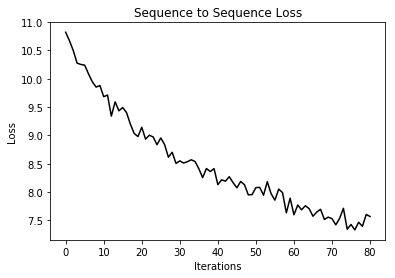

In [22]:
# Plot loss over time
plt.plot(train_loss, 'k-')
plt.title('Sequence to Sequence Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()